In [1]:
from tqdm import tqdm
import os
from copy import deepcopy
import pickle
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from datasets.ascad_datasets import AscadDataset, RandomShift, RandomNoise
from models.resnet_1d import resnet18
from models.cnn import EffNetDS50
from training.single_model import train_step, eval_step
from training.common import execute_epoch
from display_results import plot_traces

In [2]:
model = EffNetDS50((1, 700), (256,))
print(model)

EffNetDS50(
  (feature_extractor): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
    (2): SELU()
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (5): Conv1d(32, 64, kernel_size=(25,), stride=(1,), padding=(12,))
    (6): SELU()
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AvgPool1d(kernel_size=(25,), stride=(25,), padding=(0,))
    (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): SELU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  )
  (fc): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=384, out_features=15, bias=True)
    (2): SELU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features

In [3]:
epochs_per_trial = 500
device = 'cuda'
results_path = os.path.join('.', 'results', 'disc_hparam_sweep')

#hparams_to_sweep = {
#    'dataset_kwargs': [
#        {'transform': RandomShift(), 'traces_per_sample': val} for val in range(1, 3)
#    ]
#}

hparams_to_sweep = {
    'width_multiplier': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'dataset_kwargs': [
        {'transform': RandomShift(max_shift_size=n)} for n in range(20)
    ] + [
        {'transform': Compose((RandomShift(), RandomNoise(max_convex_coef=x)))} for x in np.logspace(0, 1, 20)
    ] + [
        {'transform': RandomShift(), 'mixup': True}
    ],
    'input_dropout': [1e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    'dropout': [1e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    'batch_size': [64, 128, 256, 512, 1024]
}

#hparams_to_sweep = {
#    'dataset_kwargs': [
#        #{'transform': RandomShift(max_shift_size=0), 'mixup': False},
#        {'transform': RandomShift(), 'mixup': False},
#        {'transform': Compose((RandomShift(max_shift_size=0), RandomNoise())), 'mixup': False},
#        {'transform': RandomShift(max_shift_size=0), 'mixup': True},
#        {'transform': Compose((RandomShift(), RandomNoise())), 'mixup': False},
#        {'transform': RandomShift(), 'mixup': True},
#        {'transform': Compose((RandomShift(max_shift_size=0), RandomNoise())), 'mixup': True},
#        {'transform': Compose((RandomShift(), RandomNoise())), 'mixup': True}
#    ]
#}

#hparams_to_sweep = {
#    'learning_rate': [1e-3, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
#    'weight_decay': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
#    'dropout': [0, 1e-3, 1e-2, 1e-1, 5e-1],
#    'batch_size': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}

In [4]:
#class LossFn:
#    def __init__(self):
#        self.bce_loss = nn.BCELoss()
#    def __call__(self, logits, target):
#        prediction = nn.functional.softmax(logits, dim=-1)
#        if target.shape != prediction.shape:
#            target = nn.functional.one_hot(target, num_classes=256).to(torch.float)
#        loss = self.bce_loss(prediction, target)
#        return loss

LossFn = nn.CrossEntropyLoss
from torch.optim.lr_scheduler import OneCycleLR as LRScheduler

Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:49:52<00:00, 13.14s/it]

Done. Min rank: 77.7107
	New best min rank. Previous best: inf


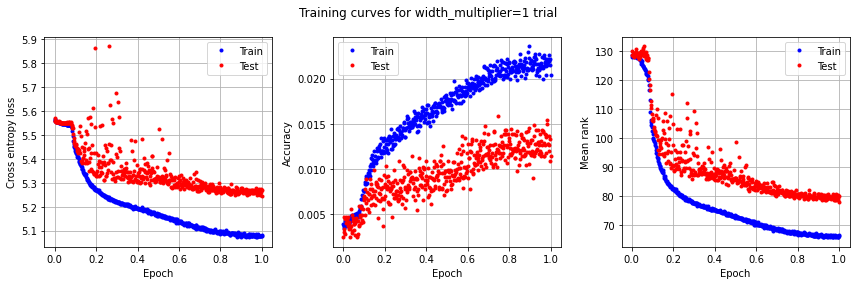







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:49:54<00:00, 13.16s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:47<1:33:05, 13.17s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [33:54<1:16:09, 13.21s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:02<58:56, 13.20s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:09<41:39, 13.16s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:18<24:37, 13.19s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:26<07:27, 13.17s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:49:54<00:00, 13.18s/it]

Done. Min rank: 81.467


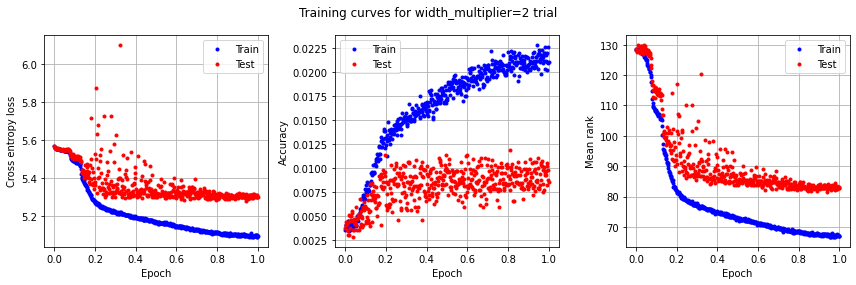







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:04<00:00, 13.21s/it]

Done. Min rank: 79.2975


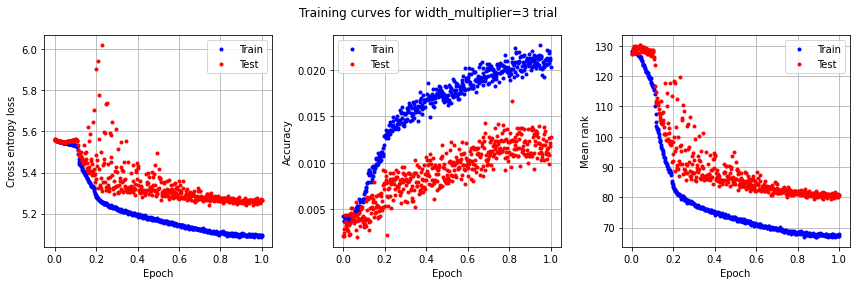







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:06<00:00, 13.19s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:48<1:32:52, 13.14s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [33:56<1:16:12, 13.22s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:05<58:54, 13.19s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:15<41:39, 13.16s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:24<24:40, 13.21s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:33<07:29, 13.22s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:02<00:00, 13.22s/it]

Done. Min rank: 82.8074


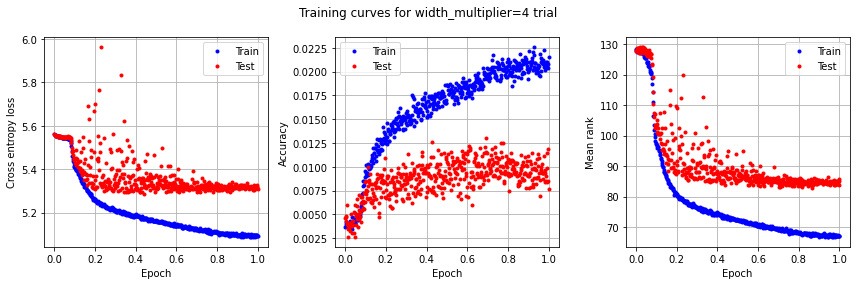







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:12<00:00, 13.20s/it]

Done. Min rank: 81.11400000000002


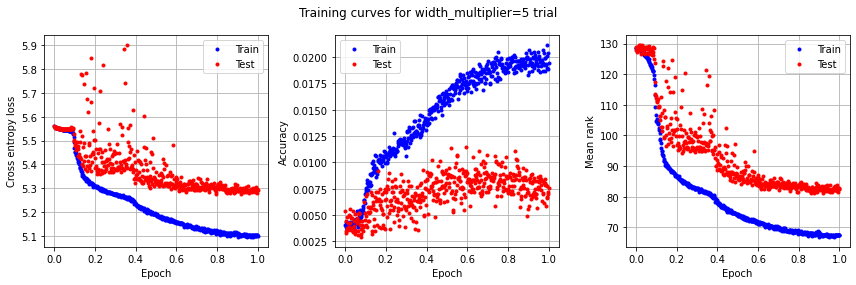







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:14<00:00, 13.20s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:50<1:33:07, 13.18s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [33:59<1:15:54, 13.16s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:09<58:52, 13.18s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:18<41:41, 13.17s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:27<24:40, 13.22s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:37<07:29, 13.22s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:06<00:00, 13.18s/it]

Done. Min rank: 82.5334


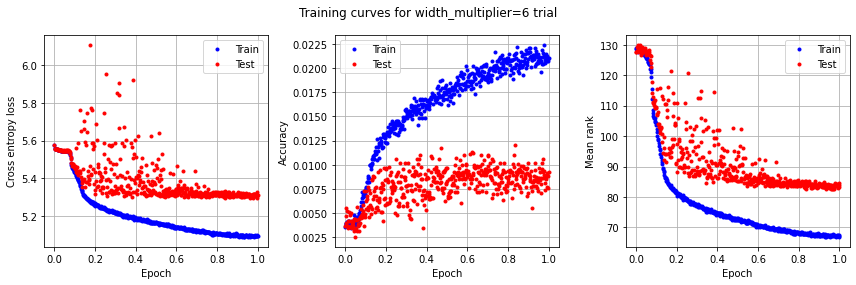







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:02<00:00, 13.15s/it]

Done. Min rank: 78.4804


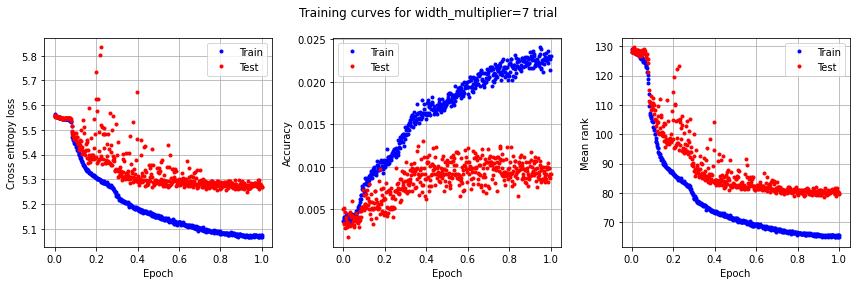







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:04<00:00, 13.18s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:49<1:33:26, 13.22s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [33:58<1:16:05, 13.19s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:08<58:56, 13.20s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:18<41:51, 13.22s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:27<24:40, 13.22s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:36<07:27, 13.16s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:04<00:00, 13.16s/it]

Done. Min rank: 78.3362


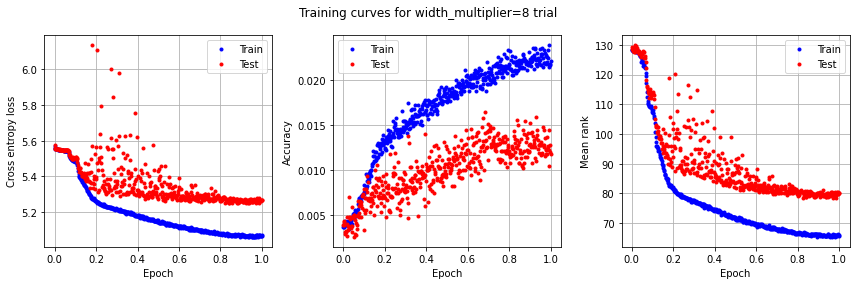







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:11<00:00, 13.22s/it]

Done. Min rank: 79.45009999999998


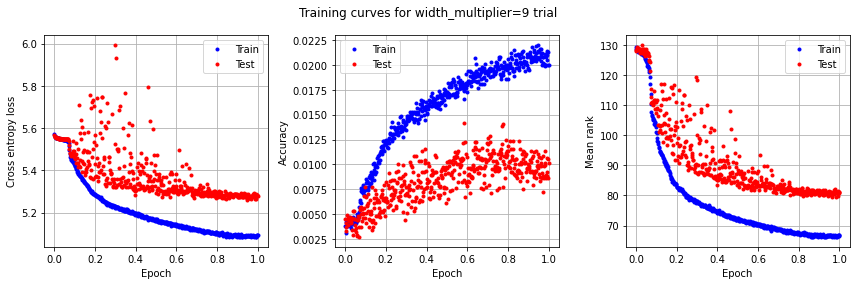







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:13<00:00, 13.20s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:49<1:33:08, 13.18s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [33:59<1:16:03, 13.19s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:08<58:49, 13.17s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:17<41:42, 13.17s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:27<24:39, 13.21s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:36<07:28, 13.19s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:04<00:00, 13.22s/it]

Done. Min rank: 77.78529999999999


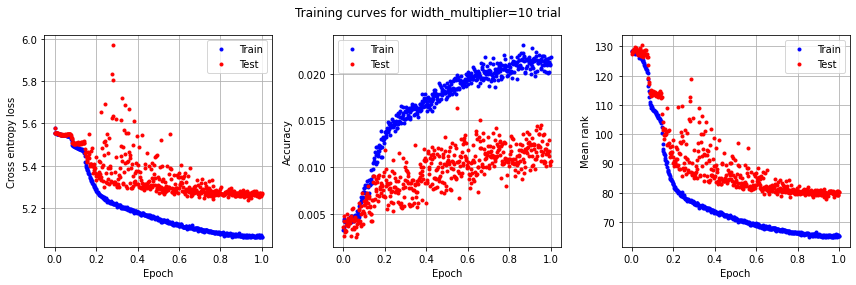







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:08<00:00, 13.22s/it]

Done. Min rank: 78.92290000000001
	New best min rank. Previous best: inf


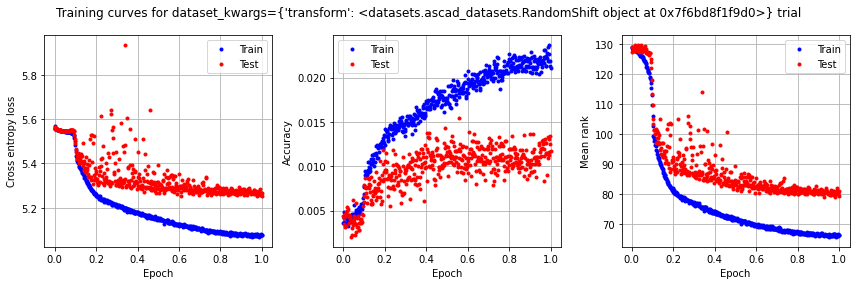







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:10<00:00, 13.19s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:49<1:33:18, 13.20s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [34:00<1:16:17, 13.23s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:10<58:57, 13.20s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:21<41:47, 13.20s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:32<24:37, 13.19s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:41<07:29, 13.22s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:10<00:00, 13.24s/it]

Done. Min rank: 80.24929999999999


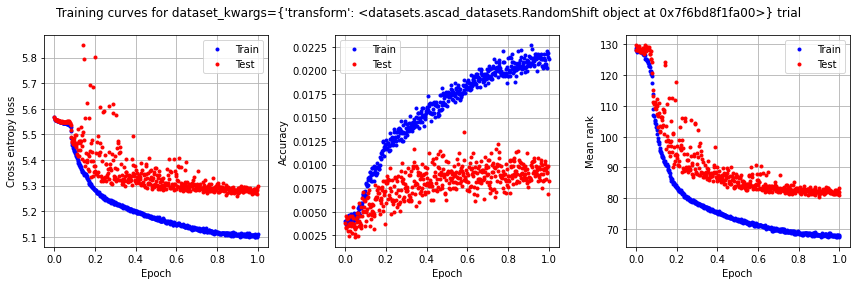







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:13<00:00, 13.22s/it]

Done. Min rank: 79.789


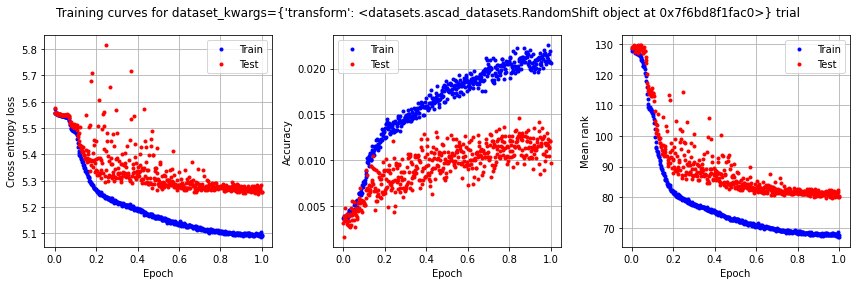







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:15<00:00, 13.21s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:50<1:33:14, 13.19s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [34:00<1:15:58, 13.17s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:09<59:05, 13.23s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:19<41:50, 13.21s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:30<24:37, 13.19s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:40<07:28, 13.20s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:09<00:00, 13.19s/it]

Done. Min rank: 79.42210000000001


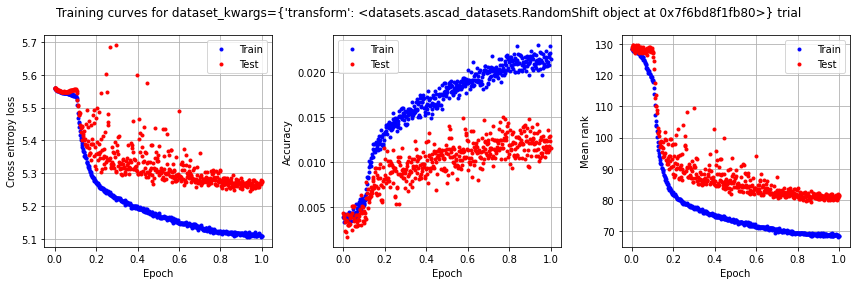







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:15<00:00, 13.20s/it]

Done. Min rank: 78.2197
	New best min rank. Previous best: 78.92290000000001


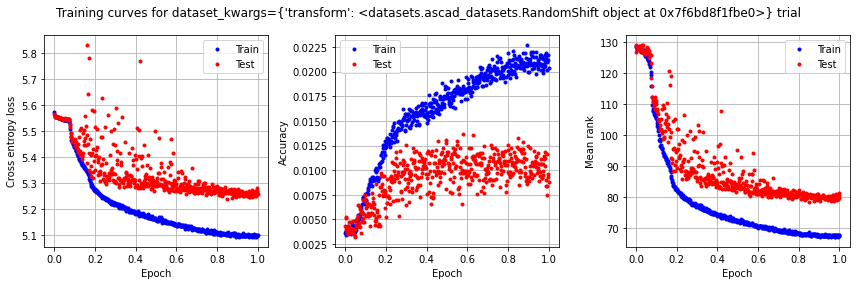







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:17<00:00, 13.21s/it]

 15%|█████████████████████████▌                                                                                                                                            | 77/501 [16:50<1:33:20, 13.21s/it]


 31%|███████████████████████████████████████████████████                                                                                                                  | 155/501 [34:02<1:16:19, 13.23s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                         | 233/501 [51:13<59:02, 13.22s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 311/501 [1:08:23<41:50, 13.21s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 389/501 [1:25:34<24:38, 13.20s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 467/501 [1:42:45<07:28, 13.19s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:14<00:00, 13.24s/it]

Done. Min rank: 77.54540000000001
	New best min rank. Previous best: 78.2197


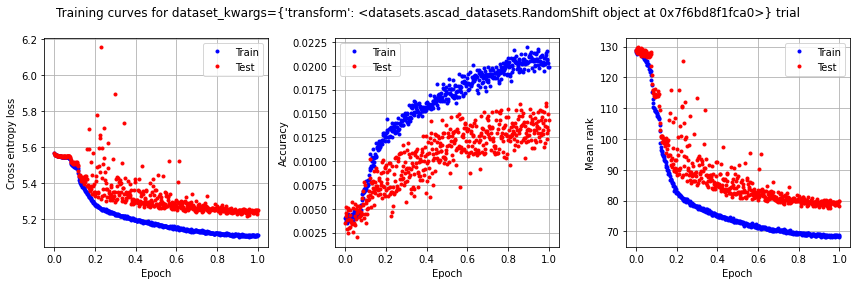







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:14<00:00, 13.18s/it]

Done. Min rank: 81.4327


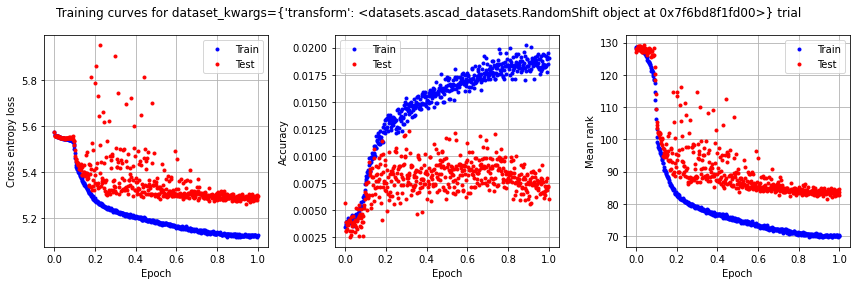







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [1:50:16<00:00, 13.21s/it]

  1%|█▎                                                                                                                                                                     | 4/501 [00:46<1:41:59, 12.31s/it]

In [ ]:
default_lr = 1e-5
default_weight_decay = 0
default_dropout = 0.
default_input_dropout = 0.
default_batch_size = 100
default_dataset_kwargs = {'transform': RandomShift()}

for hparam_name, values_to_try in hparams_to_sweep.items():
    best_min_rank = np.inf
    for value in values_to_try:
        min_rank = np.inf
        if hparam_name == 'learning_rate':
            learning_rate = value
        else:
            learning_rate = default_lr
        if hparam_name == 'weight_decay':
            weight_decay = value
        else:
            weight_decay = default_weight_decay
        if hparam_name == 'dropout':
            dropout = value
        else:
            dropout = default_dropout
        if hparam_name == 'input_dropout':
            input_dropout = value
        else:
            input_dropout = default_input_dropout
        if hparam_name == 'batch_size':
            batch_size = value
        else:
            batch_size = default_batch_size
        if hparam_name == 'dataset_kwargs':
            dataset_kwargs = value
        else:
            dataset_kwargs = default_dataset_kwargs
        print('Starting new {} trial...'.format(hparam_name))
        print('\tLearning rate: {}'.format(learning_rate))
        print('\tWeight decay: {}'.format(weight_decay))
        print('\tDropout: {}'.format(dropout))
        print('\t')
        print('\tBatch size: {}'.format(batch_size))
        if 'traces_per_sample' in dataset_kwargs:
            traces_per_sample = dataset_kwargs['traces_per_sample']
        else:
            traces_per_sample = 1
        train_dataset = AscadDataset(train=True, **dataset_kwargs)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = AscadDataset(train=False, transform=RandomShift(max_shift_size=0), traces_per_sample=traces_per_sample)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
        model = EffNetDS50((traces_per_sample, 700), (256,), width_multiplier=traces_per_sample, dropout=dropout, input_dropout=input_dropout).to(device) #resnet18(dropout=dropout).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = LRScheduler(optimizer, 1e-3, pct_start=0.2, cycle_momentum=False, epochs=epochs_per_trial, steps_per_epoch=len(train_dataloader))
        loss_fn = LossFn()
        
        def train_epoch(idx, train=True):
            if train:
                results = execute_epoch(train_step, train_dataloader,
                                        model, loss_fn, optimizer, device, callback=lr_scheduler.step)
            else:
                results = execute_epoch(eval_step, train_dataloader,
                                        model, loss_fn, device)
            with open(os.path.join(results_path, 'hparam_{}_val_{}__train_epoch_{}.pickle'.format(hparam_name, value, idx)), 'wb') as F:
                pickle.dump(results, F)
        def eval_epoch(idx):
            global min_rank
            results = execute_epoch(eval_step, test_dataloader,
                                    model, loss_fn, device)
            rank = np.mean(results['mean_rank'])
            if rank < min_rank:
                min_rank = rank
            with open(os.path.join(results_path, 'hparam_{}_val_{}__eval_epoch_{}.pickle'.format(hparam_name, value, idx)), 'wb') as F:
                pickle.dump(results, F)
        
        progress_bar = tqdm(total=epochs_per_trial+1)
        train_epoch(0, train=False)
        eval_epoch(0)
        progress_bar.update(1)
        for epoch in range(1, epochs_per_trial+1):
            train_epoch(epoch)
            eval_epoch(epoch)
            progress_bar.update(1)
        print('Done. Min rank: {}'.format(min_rank))
        
        if min_rank < best_min_rank:
            print('\tNew best min rank. Previous best: {}'.format(best_min_rank))
            best_min_rank = min_rank
            if hparam_name == 'learning_rate':
                default_lr = value
            elif hparam_name == 'weight_decay':
                default_weight_decay = value
            elif hparam_name == 'dropout':
                default_dropout = value
            elif hparam_name == 'input_dropout':
                default_input_dropout = value
            elif hparam_name == 'batch_size':
                default_batch_size = value
            elif hparam_name == 'dataset_kwargs':
                default_dataset_kwargs = value
        
        fig, axes = plot_traces(results_path, 'hparam_{}_val_{}'.format(hparam_name, value), ['loss', 'acc', 'mean_rank'], average_over_epoch=True)
        axes[0].set_ylabel('Cross entropy loss')
        axes[1].set_ylabel('Accuracy')
        axes[2].set_ylabel('Mean rank')
        fig.suptitle('Training curves for {}={} trial'.format(hparam_name, value))
        plt.tight_layout()
        plt.show()
        print('\n\n\n\n\n')